In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

In [2]:
startDate = '20200817'
endDate = '20200930'


readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### Assertion 1:  make sure same direction in same date, secid, vai
print('=======================================================================================')
print('1. same date, secid, vai: same direction')
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)][['date', 'accCode', 'secid', 'vai', 'orderDirection', 'order']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## Assertion 2:  make sure each account, secid, vai only has one insertion
print('=======================================================================================')
print('2. same date, secid, vai, accCode: one insertion')
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


### Assertion 3:  check IPO stocks selling status
print('=======================================================================================')
print('3. IPO stocks selling (ars = 301, 302)')
if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
    kk = orderLog[orderLog['ars'].isin([301, 302])]
    print(kk)
    try:
        assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
        print('we only sell, never buy')
    except:
        print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk[kk['orderDirection1'] == 1])
    kk1 = kk[kk['updateType'] == 0]
    kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
    kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
    kk1['diff'] = kk1['diff'].fillna(0)
    try:
        assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
        print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
    except:
        print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk1[kk1['diff'] < 10e6])
    kk2 = kk[(kk['updateType'] == 1)]
    try:
        assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
        print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
    except:
        print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk2[kk2['duration'] < 3e6])


### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
print('=======================================================================================')
print('4. updateType 7 orders')
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().sum() < 100)

### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
print('=======================================================================================')
print('5. updateType 6 orders')
k1 = orderLog[orderLog['updateType'] == 6].groupby('accCode')['order'].nunique().reset_index()
k2 = orderLog.groupby('accCode')['order'].nunique().reset_index()
k = pd.merge(k1, k2, on='accCode', how='left')
k['prob'] = k['order_x']/k['order_y']
try:
    assert(sum(k['prob'] >= 0.05) == 0)
except:
    print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print(k[k['prob'] >= 0.05])

### Assertion 6: check CYB orders, make sure CYB stocks total absOrderSize < 30w
print('=======================================================================================')
print('6. CYB stocks total order size < 30w')
try:
    assert(orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)]['absOrderSize'].max() <= 300000)
except:
    print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    
     
### Assertion 7:  make sure there is no unexpected updateType 
print('=======================================================================================')
print('7. unexpected updateType')
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                               (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                               (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### Assertion 8:  make sure status==0 got all traded
print('=======================================================================================')
print('8. status == 0: all traded')
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 9:  make sure status==1 got partial traded
print('=======================================================================================')
print('9. status == 1: partial traded')
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 10: make sure no cancellation within 1 sec
print('=======================================================================================')
print('10. no cancellation within 1 sec')
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


### Assertion 11: make sure no order has shares > 80w or notional > 800w
print('=======================================================================================')
print('11. Orders with size > 80w or notional > 800w')
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
orderLog

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\User

1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
181375,20200817,5275,2300130,22789836,-1,4225
181381,20200817,8854,2300130,22789836,1,17799
493387,20200819,5269,2002296,7540400,1,84990
493390,20200819,6480,2002296,7540400,1,95849
493394,20200819,9741,2002296,7540400,-1,112401
...,...,...,...,...,...,...
8280331,20200930,6623,2002677,1616000,-1,1976780
8280335,20200930,6627,2002677,1616000,-1,1977868
8280339,20200930,8854,2002677,1616000,1,1980468
8280342,20200930,8865,2002677,1616000,-1,1981045


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200817,9741,2300486,614300,33811,2
1,20200817,9741,2300812,234182,34442,2
2,20200817,9756,2300652,276800,38984,2
3,20200818,9741,1603059,338875,71977,2
4,20200818,9741,1603322,2165088,72103,2
...,...,...,...,...,...,...
1746,20200930,9741,2002735,1029020,1994023,2
1747,20200930,9741,2002802,340600,1994126,2
1748,20200930,9741,2300492,151700,1994926,2
1749,20200930,9741,2300522,1074820,1995012,2


91.60% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
15165,18002,3400,4300
15346,18202,3500,4000
16782,20053,3000,8800
24712,29751,1300,2300
24966,30065,12500,15100
...,...,...,...
1493431,2007346,500,800
1493531,2007467,19050,49000
1493866,2007895,19500,23300
1495625,2010657,500,700


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w
some order ntl are > 800w
colo      accCode
zt_52_04  526901     1
zt_88_03  8970       1
Name: order, dtype: int64


,date,accCode,secid,vai,absOrderSize,orderPrice,orderNtl,orderDirection,clock,order,updateType,tradePrice,absOrderSizeCumFilled,absFilledThisUpdate
47863,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:24.812938,20609,0,-1.00,0,0
47864,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:25.029895,20609,2,-1.00,0,0
47865,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:25.438086,20609,4,80.88,1400,1400
47866,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:25.440527,20609,4,80.89,1500,100
47867,20200817,8970,1601318,49810664,98900,80.89,8000021.0,1,2020-08-17 10:03:25.440710,20609,4,80.89,1600,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253417,20200818,526901,1600988,49123963,347900,23.00,8001700.0,1,2020-08-18 09:51:55.168804,77277,4,23.00,342146,500
253418,20200818,526901,1600988,49123963,347900,23.00,8001700.0,1,2020-08-18 09:51:55.169252,77277,4,23.00,342246,100
253419,20200818,526901,1600988,49123963,347900,23.00,8001700.0,1,2020-08-18 09:51:55.169697,77277,4,23.00,343246,1000
253420,20200818,526901,1600988,49123963,347900,23.00,8001700.0,1,2020-08-18 09:51:55.170122,77277,4,23.00,343446,200


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status,orderNtl,exchange,tradeNtl,sta
0,0,1597644521482187,1597644521482048,1600000,0,84071789,121.0,0,1,300,0,10.77,-1.00,20200817,537401,100,zt_52_07,NaN,698.0,NaN,140831000.0,0.002178,4849646.0,0.002420,0.002420,0.002178,-0.003221,84071789.0,1076.0,1077.0,0.0,2020-08-17 14:08:41.482187,53,zt_53,46146,0,1597644521482187,0,1,1,1.0,0,3231.0,SSE,0.0,statwo
1,1,1597644521642948,1597644521482048,1600000,2,84071789,121.0,0,1,300,0,10.77,-1.00,20200817,537401,0,zt_52_07,192323,698.0,NaN,-1.0,-1.000000,0.0,0.002420,-1.000000,0.002178,-0.003221,84071789.0,1076.0,1077.0,0.0,2020-08-17 14:08:41.642948,53,zt_53,46146,0,1597644521482187,160761,1,1,1.0,0,3231.0,SSE,0.0,statwo
2,2,1597644521784444,1597644521482048,1600000,4,84071789,121.0,300,1,300,300,10.77,10.77,20200817,537401,0,zt_52_07,NaN,698.0,25786667.0,-1.0,-1.000000,0.0,0.002420,-1.000000,0.002178,-0.003221,84071789.0,1076.0,1077.0,0.0,2020-08-17 14:08:41.784444,53,zt_53,46146,0,1597644521482187,302257,1,1,1.0,0,3231.0,SSE,3231.0,statwo
3,3,1597628235977816,1597628235977635,1600004,0,3765525,131.0,0,1,800,0,14.91,-1.00,20200817,527501,23,zt_52_05,NaN,401.0,NaN,93709000.0,0.001419,0.0,0.002929,0.002929,0.001419,-0.002012,3765525.0,1490.0,1491.0,0.0,2020-08-17 09:37:15.977816,52,zt_52,42094,1,1597628235977816,0,1,1,0.0,1,11928.0,SSE,0.0,statwo
4,4,1597628236160575,1597628235977635,1600004,2,3765525,131.0,0,1,800,0,14.91,-1.00,20200817,527501,0,zt_52_05,47924,401.0,NaN,-1.0,-1.000000,0.0,0.002929,-1.000000,0.001419,-0.002012,3765525.0,1490.0,1491.0,0.0,2020-08-17 09:37:16.160575,52,zt_52,42094,1,1597628235977816,182759,1,1,0.0,1,11928.0,SSE,0.0,statwo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364162,269619,1601445024552930,1601445024550859,2300815,4,278616,131.0,100,-1,300,200,108.78,108.78,20200930,8865,0,zs_88_04,AE22004576,1283.0,1.04e+14,-1.0,-1.000000,0.0,0.000535,-1.000000,-0.001404,0.001328,279716.0,10877.0,10878.0,0.0,2020-09-30 13:50:24.552930,88,zs_88,1981531,1260849,1601445024545784,7146,-1,1,1.0,0,32634.0,SZE,10878.0,statwo
8364163,269620,1601445030812885,1601445030811784,2300815,4,278616,131.0,100,-1,300,300,108.78,108.78,20200930,8865,0,zs_88_04,NaN,1283.0,1.04e+14,-1.0,-1.000000,0.0,0.000421,-1.000000,-0.001462,0.001134,279916.0,10877.0,10880.0,0.0,2020-09-30 13:50:30.812885,88,zs_88,1981531,1260849,1601445024545784,6267101,-1,1,1.0,0,32634.0,SZE,10878.0,statwo
8364164,269621,1601445033468652,1601445033468597,2300815,0,280216,131.0,0,-1,100,0,108.76,-1.00,20200930,8865,100,zs_88_04,NaN,1289.0,NaN,135030000.0,0.000753,13327681.0,0.000080,0.000080,-0.001097,0.000753,280216.0,10876.0,10877.0,0.0,2020-09-30 13:50:33.468652,88,zs_88,1981532,1260850,1601445033468652,0,-1,1,1.0,0,10876.0,SZE,0.0,statwo
8364165,269622,1601445033474488,1601445033473674,2300815,2,280216,131.0,0,-1,100,0,108.76,-1.00,20200930,8865,0,zs_88_04,AE22004584,1289.0,NaN,-1.0,-1.000000,0.0,0.000006,-1.000000,-0.001092,0.000694,280316.0,10875.0,10877.0,0.0,2020-09-30 13:50:33.474488,88,zs_88,1981532,1260850,1601445033468652,5836,-1,1,1.0,0,10876.0,SZE,0.0,statwo


In [4]:
print('SZE')
totalAccount = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['colo'].str[:5].isin(['zs_52', 'zt_52']))]['accCode'].unique()
for date, dateLog in orderLog[orderLog['secid'] >= 2000000].groupby(['date']):
    dailyAccount = dateLog['accCode'].unique()
    print(date, sorted(list(set(totalAccount) - set(dailyAccount))))
print(totalAccount)
print('SSE')
totalAccount = orderLog[(orderLog['secid'] < 2000000) & (orderLog['colo'].str[:5].isin(['zs_52', 'zt_52']))]['accCode'].unique()
for date, dateLog in orderLog[orderLog['secid'] < 2000000].groupby(['date']):
    dailyAccount = dateLog['accCode'].unique()
    print(date, sorted(list(set(totalAccount) - set(dailyAccount))))
print(totalAccount)

SZE
20200817 [5222, 5225, 5226, 5229, 5230, 5286, 5287, 5289, 5290, 5291, 5386, 537403]
20200818 [5222, 5225, 5226, 5229, 5230, 5286, 5287, 5289, 5290, 5291, 5386, 537403]
20200819 [5222, 5225, 5226, 5229, 5230, 5286, 5287, 5289, 5290, 5291, 5386, 537403]
20200820 [5222, 5225, 5226, 5229, 5230, 5286, 5287, 5289, 5290, 5291, 5386, 537403]
20200821 [5222, 5225, 5226, 5229, 5230, 5286, 5287, 5289, 5290, 5291, 5386, 537403]
20200824 [5222, 5225, 5226, 5229, 5230, 5286, 5287, 5289, 5290, 5291, 5386, 537403]
20200825 [5222, 5225, 5226, 5229, 5230, 5286, 5289, 5290, 5291, 5386, 537403]
20200826 [5222, 5225, 5226, 5229, 5230, 5286, 5289, 5290, 5291, 5386, 537403]
20200827 [5222, 5225, 5226, 5229, 5230, 5286, 5289, 5290, 5291, 5386, 537403]
20200828 [5222, 5225, 5226, 5229, 5230, 5289, 5290, 5291, 5386, 537403]
20200831 [5222, 5225, 5226, 5229, 5230, 5291, 5386, 537403]
20200901 [5222, 5225, 5226, 5229, 5230, 5291, 5386, 537403]
20200902 [5222, 5225, 5226, 5229, 5230, 5291, 5386, 537403]
202009

In [5]:
checkLog = orderLog[orderLog['updateType'] == 0].reset_index(drop=True)
checkLog['brokerNum'] = checkLog.groupby(['date', 'secid', 'vai'])['accCode'].transform('nunique')
order_list = checkLog[(checkLog['exchange'] == 'SSE') & (checkLog['colo_broker'] == 'zt_52')
             & (checkLog["brokerNum"] >= 2)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re1 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re1['fill rate'] = re1['tradeNtl'] / re1['orderNtl']

order_list = checkLog[(checkLog['exchange'] == 'SSE') & (checkLog['colo_broker'] == 'zt_52')
             & (checkLog["brokerNum"] == 1)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re2 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re2['fill rate'] = re2['tradeNtl'] / re2['orderNtl']

order_list = checkLog[(checkLog['exchange'] == 'SZE') & (checkLog['colo_broker'] == 'zs_52')
             & (checkLog["brokerNum"] >= 2)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re3 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re3['fill rate'] = re3['tradeNtl'] / re3['orderNtl']

order_list = checkLog[(checkLog['exchange'] == 'SZE') & (checkLog['colo_broker'] == 'zs_52')
             & (checkLog["brokerNum"] == 1)]['order'].unique()
d1 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4) & (orderLog['order'].isin(order_list))].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
re4 = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
re4['fill rate'] = re4['tradeNtl'] / re4['orderNtl']

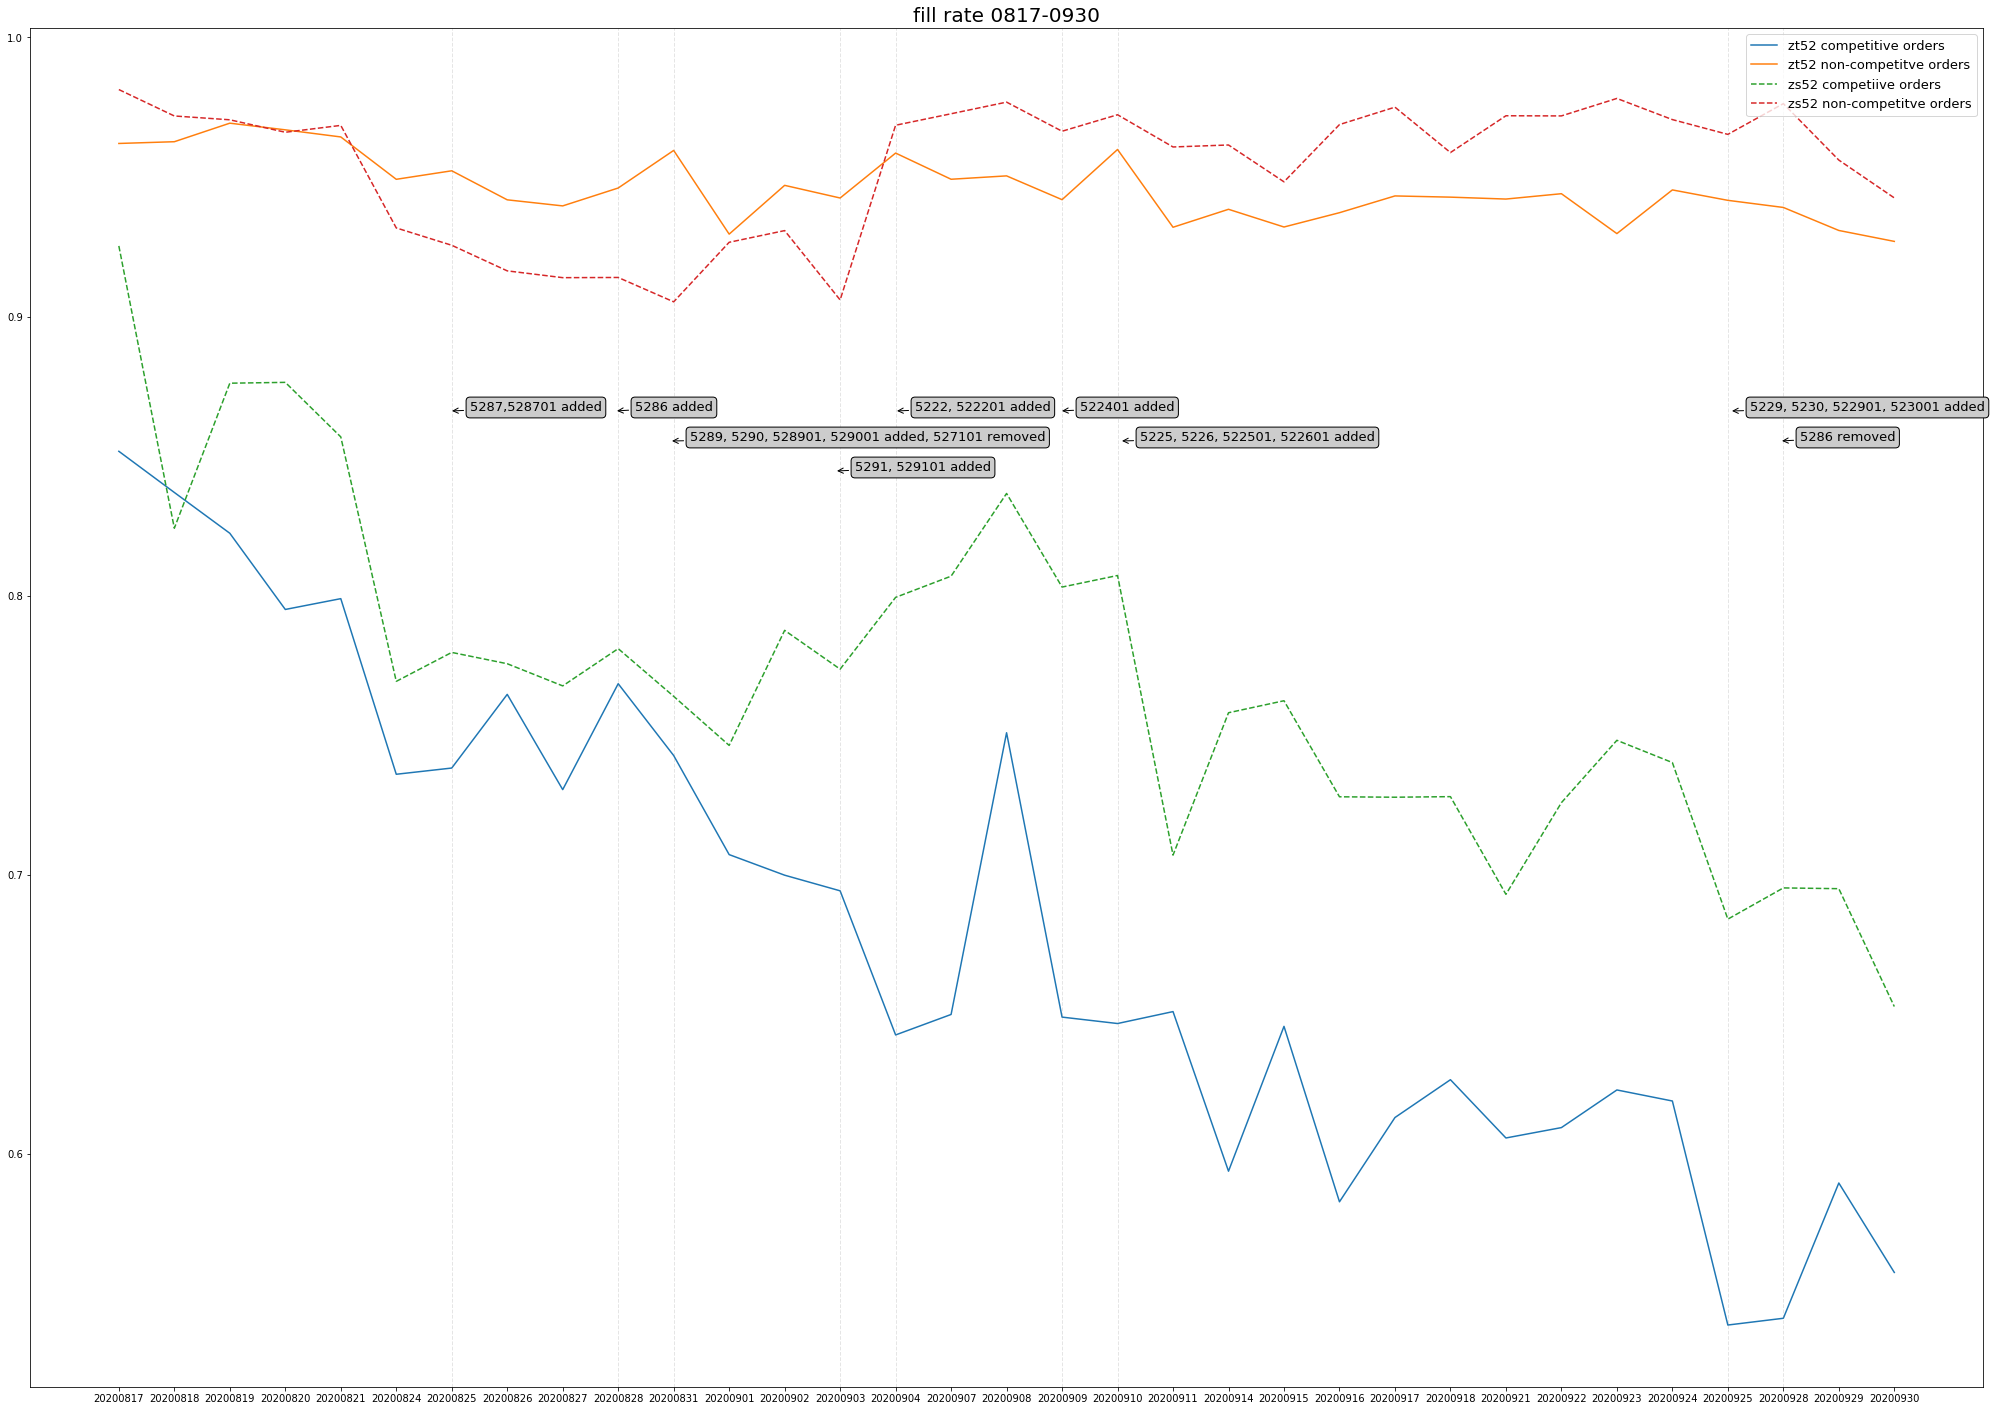

In [41]:
fig = plt.figure(figsize=(35, 25))
ax = fig.add_subplot(111)
ax.plot(re1['fill rate'].values, label='zt52 competitive orders')
ax.plot(re2['fill rate'].values, label='zt52 non-competitve orders')
ax.plot(re3['fill rate'].values, label='zs52 competiive orders', linestyle='dashed')
ax.plot(re4['fill rate'].values, label='zs52 non-competitve orders', linestyle='dashed')


ax.set_title('fill rate 0817-0930', fontsize=20)
indexLs = [i for i in range(re1.shape[0])]
dateLs = [int(i) for i in re1['date'].values]
ax.set_xticks(indexLs)
ax.set_xticklabels(dateLs)
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes, fontsize=13)
plt.axvline(x=6,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=9,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=10,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=13,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=14,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=17,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=18,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=29,ls="--",c="grey", alpha=0.2, lw=1)
plt.axvline(x=30,ls="--",c="grey", alpha=0.2, lw=1)
bbox = dict(boxstyle="round", fc="0.8")
arrowprops = dict(
    arrowstyle = "->")
ax.annotate('5287,528701 added', (450, 1000), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops, fontsize=13)
ax.annotate('5286 added', (615, 1000), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops, fontsize=13)
ax.annotate('5289, 5290, 528901, 529001 added, 527101 removed', (670, 970), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops, fontsize=13)
ax.annotate('5291, 529101 added', (835, 940), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops, fontsize=13)
ax.annotate('5222, 522201 added', (895, 1000), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops, fontsize=13)
ax.annotate('522401 added', (1060, 1000), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops, fontsize=13)
ax.annotate('5225, 5226, 522501, 522601 added', (1120, 970), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops, fontsize=13)
ax.annotate('5229, 5230, 522901, 523001 added', (1730, 1000), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops, fontsize=13)
ax.annotate('5286 removed', (1780, 970), xytext=(20, 0), xycoords='figure pixels', textcoords='offset points',
            bbox=bbox, arrowprops=arrowprops, fontsize=13)
plt.xticks(fontsize=10)
plt.show()